# **Jobsheet 10: Recurrent Neural Network (RNN)**

Maria Fadilla

## **Praktikum 1 - RNN untuk Analisis Sentimen**

### Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets). Lihat [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"If you cannot enjoy a chick flick, stop right now. If, however, you enjoy films that illustrate complex characters and provide extraordinary acting, read on.<br /><br />Ann Grant Lord is dying. Her two daughters arrive to be at her bedside. Ann begins talking about people from her past of whom the daughters are unaware, and they question as to whether these lost acquaintances are real or imagined. They come to realize that these people from their mother's past are, indeed, real.<br /><br />The story shifts, basically, between 1953 and circa 2000 with a few glimpses at Ann's life between those years. It was in 1953 that Ann met the love of her life and experienced her life's greatest tragedy.<br /><br />One of Ann's two best friends from college, Lila, is being married. Ann's other best friend is Lila's brother, Buddy. Lila and Buddy are the children of a rich Newport family, whereas Ann is a cabaret singer living in Greenwich Village who wants to be a free spirit but is stil

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap)

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 45,  23, 543, ...,   1, 100,  73],
       [448,  21, 185, ...,   0,   0,   0],
       [825,   1, 545, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"If you cannot enjoy a chick flick, stop right now. If, however, you enjoy films that illustrate complex characters and provide extraordinary acting, read on.<br /><br />Ann Grant Lord is dying. Her two daughters arrive to be at her bedside. Ann begins talking about people from her past of whom the daughters are unaware, and they question as to whether these lost acquaintances are real or imagined. They come to realize that these people from their mother's past are, indeed, real.<br /><br />The story shifts, basically, between 1953 and circa 2000 with a few glimpses at Ann's life between those years. It was in 1953 that Ann met the love of her life and experienced her life's greatest tragedy.<br /><br />One of Ann's two best friends from college, Lila, is being married. Ann's other best friend is Lila's brother, Buddy. Lila and Buddy are the children of a rich Newport family, whereas Ann is a cabaret singer living in Greenwich Village who wants to be a free spirit but is st

### **Buat Model**

![image.png](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  * Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  * Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse)

Lapisan penyematan menggunakan masking ([uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding)) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali.
Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.01241296]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang.
Hasilnya harus sama

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 343ms/step
[-0.01241296]


compile model Keras untuk mengonfigurasi proses pelatihan

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 713s 2s/step - loss: 0.6359 - accuracy: 0.5800 - val_loss: 0.4902 - val_accuracy: 0.7719
Epoch 2/10
391/391 [==============================] - 645s 2s/step - loss: 0.4392 - accuracy: 0.7886 - val_loss: 0.4132 - val_accuracy: 0.7948
Epoch 3/10
391/391 [==============================] - 654s 2s/step - loss: 0.3668 - accuracy: 0.8385 - val_loss: 0.3744 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 653s 2s/step - loss: 0.3360 - accuracy: 0.8526 - val_loss: 0.3495 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 642s 2s/step - loss: 0.3198 - accuracy: 0.8603 - val_loss: 0.3343 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 658s 2s/step - loss: 0.3096 - accuracy: 0.8666 - val_loss: 0.3310 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 659s 2s/step - loss: 0.3050 - accuracy: 0.8707 - val_loss: 0.3207 - val_accuracy: 0.8573

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 150s 383ms/step - loss: 0.3177 - accuracy: 0.8624
Test Loss: 0.31771665811538696
Test Accuracy: 0.8623600006103516


(0.0, 0.6528735220432281)

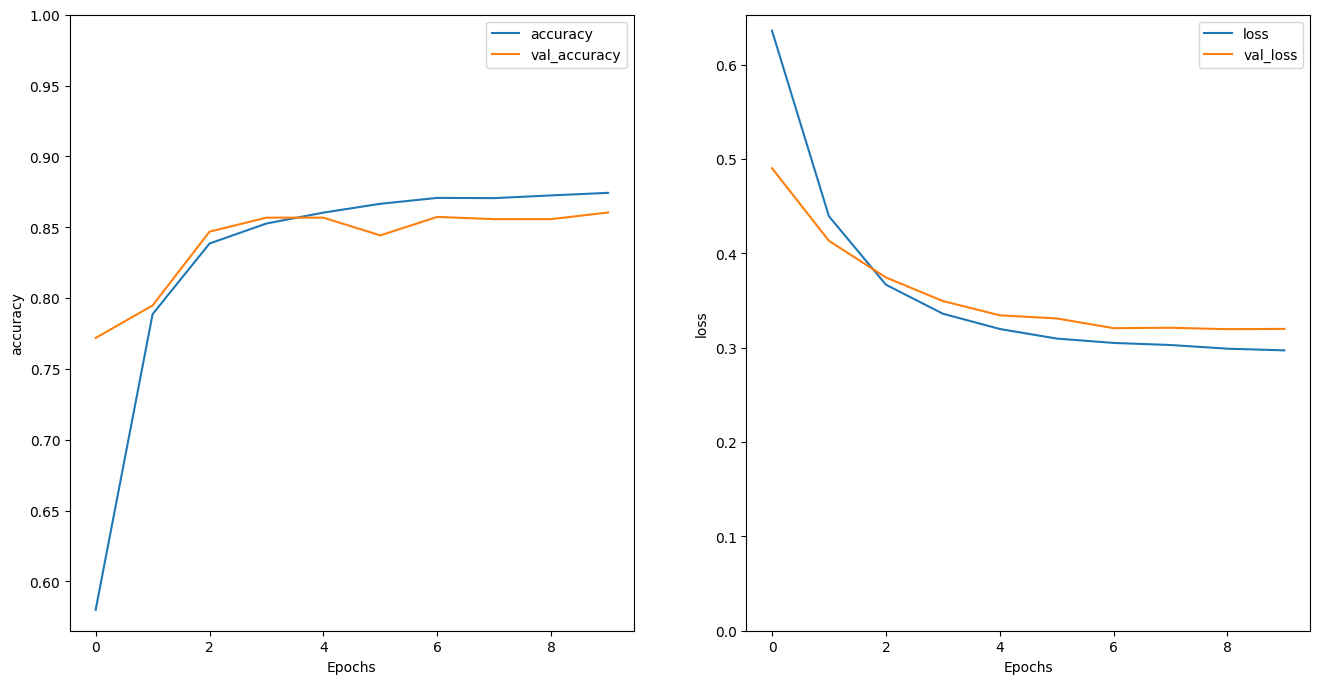

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru.

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 0s 140ms/step


### **Stack two or more LSTM layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
  * Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
  * Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

![image.png](https://www.tensorflow.org/static/text/tutorials/images/layered_bidirectional.png)

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1350s 3s/step - loss: 0.6477 - accuracy: 0.5665 - val_loss: 0.4495 - val_accuracy: 0.7792
Epoch 2/10
391/391 [==============================] - 1252s 3s/step - loss: 0.3863 - accuracy: 0.8322 - val_loss: 0.3496 - val_accuracy: 0.8531
Epoch 3/10
391/391 [==============================] - 1282s 3s/step - loss: 0.3359 - accuracy: 0.8572 - val_loss: 0.3357 - val_accuracy: 0.8375
Epoch 4/10
391/391 [==============================] - 1270s 3s/step - loss: 0.3198 - accuracy: 0.8634 - val_loss: 0.3342 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 1260s 3s/step - loss: 0.3101 - accuracy: 0.8696 - val_loss: 0.3299 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 1247s 3s/step - loss: 0.3019 - accuracy: 0.8719 - val_loss: 0.3140 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 1273s 3s/step - loss: 0.3003 - accuracy: 0.8716 - val_loss: 0.3135 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 293s 749ms/step - loss: 0.3151 - accuracy: 0.8611
Test Loss: 0.3150779604911804
Test Accuracy: 0.8611199855804443


In [ ]:
# predict on a sample text without padding.
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 17s 17s/step
[[-1.724744]]


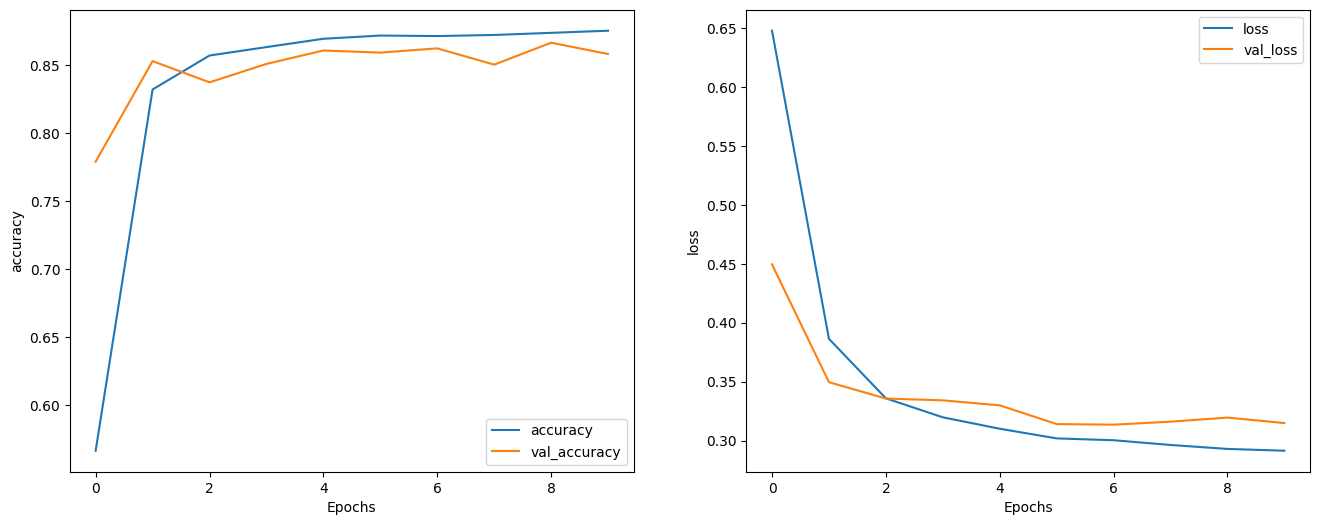

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **Praktikum 2 - Generator Teks dengan RNN**

Praktikum ini mendemonstrasikan cara melakukan genearsi text menggunakan RNN. Dataset yang digunkan adalah dataset Shakespeare's writing from Andrej Karpathy's . Jika diberikan urutan karakter dari data ini ("Shakespear"), latih model untuk memprediksi karakter berikutnya dalam urutan ("e"). Urutan teks yang lebih panjang dapat dihasilkan dengan memanggil model berulang kali.
Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.
Tutorial ini menggunakan tf.keras dan eager execution. Berikut adalah contoh output ketika model dalam tutorial ini dilatih selama 30 epoch, dan dimulai dengan prompt "Q":

### **Setup**

#### Import TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

#### **Download Dataset Shakespeare**

Sesuaikan dengan lokasi data yang Anda punya.

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


#### **Load Data**

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### **Olah Teks**

#### **Vectorize Teks**

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. `tf.keras.layers.StringLookup` dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [7]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat `tf.keras.layers.StringLookup` layer

In [8]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [9]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode
`tf.keras.layers.StringLookup(..., invert=True)`.

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode `get_vocabulary()` dari
`tf.keras.layers.StringLookup` sehingga token [UNK] disetel dengan cara yang sama.

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter `tf.RaggedTensor`

In [11]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan `tf.strings.reduce_join` untuk menggabungkan kembali karakter menjadi string.

In [12]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [13]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

#### **Prediksi**

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

#### **Membuat Trianing Set dan Target**

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian `seq_length+1`. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi `tf.data.Dataset.from_tensor_slices` untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [14]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [15]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [16]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [17]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string

In [18]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu

In [19]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [20]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [21]:
dataset = sequences.map(split_input_target)

In [22]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### **Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [23]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)).

Model yang kita bangun memiliki 3 lapisan neural network :

  * `tf.keras.layers.Embedding`: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
  * `tf.keras.layers.GRU`: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
  * `tf.keras.layers.Dense`: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [24]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [25]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [26]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:

![image.png](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_training.png?raw=1)

Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

### **Uji Model**

Coba jalankan model dan cek apakah sidah sesuai dengan output

pertama, cek bentuk dari output

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [ ]:
sampled_indices

array([11, 31, 52, 36,  3, 59, 26, 57,  6, 38, 41, 18, 50, 42,  2, 45, 28,
       10, 46, 27, 60, 47, 16, 53, 25, 25,  0, 28, 49, 39, 22, 41, 55, 21,
       59,  2, 29, 63, 10,  9, 51, 26,  7, 32, 62, 19, 33, 15, 26, 35,  2,
       17, 13, 43, 33, 62, 12, 25, 65, 61, 33, 39,  9, 29, 45, 30, 34, 62,
       39, 35,  0, 17, 64, 49, 56, 57,  6, 16, 15, 40,  4, 12,  0, 40, 19,
       56, 44, 10, 23, 46,  1, 24, 33, 37, 38, 31, 60, 29, 21, 10])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" so early made.\nThe earth hath swallow'd all my hopes but she,\nShe is the hopeful lady of my earth:\n"

Next Char Predictions:
 b":RmW!tMr'YbEkc fO3gNuhCnLL[UNK]OjZIbpHt Px3.lM,SwFTBMV D?dTw;LzvTZ.PfQUwZV[UNK]Dyjqr'CBa$;[UNK]aFqe3Jg\nKTXYRuPH3"


### **Train Model**

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

##### **Tambahan optimizer dan fungsi loss**

loss function `tf.keras.losses.sparse_categorical_crossentropy` standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur `flag from_logits`.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1894712, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.98789

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [ ]:
model.compile(optimizer='adam', loss=loss)

##### **Konfigurasi Checkpoints**

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [32]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

##### **Lakukan Proses Training**

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 635s 4s/step - loss: 2.7455
Epoch 2/20
172/172 [==============================] - 599s 3s/step - loss: 2.0041
Epoch 3/20
172/172 [==============================] - 599s 3s/step - loss: 1.7223
Epoch 4/20
172/172 [==============================] - 597s 3s/step - loss: 1.5590
Epoch 5/20
172/172 [==============================] - 597s 3s/step - loss: 1.4591
Epoch 6/20
172/172 [==============================] - 597s 3s/step - loss: 1.3896
Epoch 7/20
172/172 [==============================] - 597s 3s/step - loss: 1.3358
Epoch 8/20
172/172 [==============================] - 597s 3s/step - loss: 1.2902
Epoch 9/20
172/172 [==============================] - 599s 3s/step - loss: 1.2482
Epoch 10/20
172/172 [==============================] - 597s 3s/step - loss: 1.2078
Epoch 11/20
172/172 [==============================] - 599s 3s/step - loss: 1.1686
Epoch 12/20
172/172 [==============================] - 597s 3s/step - loss: 1.1270
Epoch 13/20
1

### **Generate Teks**

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

![image.png](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Thln me sorsdeavn tf, Liurssou sr le this thonn IlAt!?

AADAsO:

yCJly s,e she, o-'sil the tiy ieoaterl vopth sale blid wous Iope: so, th ou d baf oreH iorannt; wth bplapavafealit ouesy ypeves Ione.
I
AoR&OvGous moc, tricI
cI
hethe pany nfonce iut fel
ancitb oorl thanou,, youd throule fone Vwc?
-L!
HKWMangC?

Wbaocsthee fells: heacen thers fwars.
o
s,?
Z
AL&RX!'MO,:
-.

BQD:QEVBVZH
Q?3Fbday fay ;

AA wagiha har onche'thin fy:
I


FEardg he
y anigor mitenevek
SaWse pelap, fsy couet, whenrll, bc't Ied hunls.

R&P&QzO IrI eoud wif tou cot amaf legs mtot tank mhlifiT, sakhrtat hat dours valrghy hou or tiid fot they wof besy mor mon'cuot lr bek athey Iou.
T:'ud mve.3Mcimt mut eomeler she
d cere, dgasspofl.
NZ kghaeow, ioutbe orechis at an sare, Rnble theret sos wad,:

nre aren aounbe,

sSHaver:

S;
IER
T!
FFmid torr frer, save chat npcathin ourimit, 'nus:
I
wen' ke

AU
EMI3
Opm'csi
ipnved whe d haker chan am mer too therl:

AWwind yob pil is soreld R thers hl icirlsss,
A
BArokk m ich

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\n\nfuga.\n\n&NaWIcmerere go cetot for deg boury mallloul, gy l the may bor ut:\n\nMprir oo les the\nC\nW otty.\nRWAKAverrI mcit oamkkrif ve ood phithan' moke arlven, hhthfd ser we ily Ir ris aaulr 'retle bhan giml 'ninsesy ha.\nCMuritinqlco, I\ny hy aoriche mos nitrg\nslovy aler oiangrss he s in main.\nAI!\nYSBtHy me fomhoute\nTherk: mare wowre thit hangve athe lontonwd lound rveorafla dore sol,, ghanil; theuther wow ool!xfr he nd sthal cois pe d harelr id uh ns y pe ther\nd\nhr sh ptin oreg\n\nL\nR&D:Wher Thin;\n\nWhed w orp!\ntsuse\nABThbin be ther atolr as hid sint be liquv aore was hikves nher eare iou fere:\n\nS\nMlors pesrs, fte, Is vart meile sorey is aor god pound thaas win a forl byou , min's ghiktrnr whae inpe mg.\n\nY\nAEWhea\nllis hat to.\nA\nWhe're y, po yod\no\n\nSTinoy sild her vis te ore heawze ther toucc sthae, chy hoe, mey oos wbet ho wor llmesl y heesosy talry, dongvetod car ing riweveslr, AsldreThara,claHor thof aouth aa th stlancibshim thanhe a

### **Ekspor Model Generator**

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:s motoue Iy Iod cwere' ve iol inouwicafws thinmoed.
RYOWesinr.

O
WbEan; yee
osfscime ise tary ther 


## **TUGAS**

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan.

Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan `tf.GradientTape` untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca [eager execution guide](https://www.tensorflow.org/guide/eager).

Prosedurnya adalah:
  1. Jalankan Model dan hitung loss dengan tf.GradientTape.
  2. Hitung update dan terapkan pada model dengan optimizer

#### **Kode Program**

In [27]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras [`Model.compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [`Model.fit methods`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

In [28]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [29]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [30]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 20s 52ms/step - loss: 2.6999


In [33]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 1.2975
Epoch 1 Batch 50 Loss 1.2969
Epoch 1 Batch 100 Loss 1.3357
Epoch 1 Batch 150 Loss 1.2886

Epoch 1 Loss: 1.3242
Time taken for 1 epoch 11.53 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.2550
Epoch 2 Batch 50 Loss 1.2804
Epoch 2 Batch 100 Loss 1.2866
Epoch 2 Batch 150 Loss 1.2821

Epoch 2 Loss: 1.2788
Time taken for 1 epoch 10.87 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.2040
Epoch 3 Batch 50 Loss 1.2449
Epoch 3 Batch 100 Loss 1.2336
Epoch 3 Batch 150 Loss 1.2286

Epoch 3 Loss: 1.2373
Time taken for 1 epoch 10.76 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.2041
Epoch 4 Batch 50 Loss 1.1995
Epoch 4 Batch 100 Loss 1.2187
Epoch 4 Batch 150 Loss 1.1961

Epoch 4 Loss: 1.1972
Time taken for 1 epoch 10.96 sec
_____________________________________________________________________

##### **Prediction: Generate Teks**

In [34]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [35]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [38]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Madam, I'll crave you, catting wall:
My love am bound to share a case to go in.
I'll tell him of this dire my war, my sick and threatenant
And help to revenee from whence the son:--trengs that parlia:
What dog bable his noble cousin! farlwoo, whose name
answer to the sea for a holemisy here,
And he shall I frian 'O, that your ments did church,
Make haste, and kissing once I'll keep thee come.

HORTENSS:
I' the rile convey'd to attended new marriage, do me;
And that was would absolute lives, gentlemen.

BRUTUS:
But, I pray you, take lengthen of waterthly.

DUKE VINCENTO:

Third Servingman:
Aution, gaplain, ere it be dishonour'd rule,
Tell her shall have my swift consent,
As 'lastor to my heaviest ape,
Put not an Edward, with a bloody sin
Is the mut and tell the bentremes of some other.
Make admits me have perform'd from belly,
Do palua against my throne. Mend your
But sweet and only charges to be.

BUCKINGHAM:
Upon God and that she was one or our knees,
We shall not wont both som

In [39]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nBut only his won my saints? what noble cousin\nHath yield your liveries; and, as the Earl of Warwick flints\nhopes with otherwill's bred bids in deach he hath\nWere four and unecentany.\n\nThird Citizen:\nAt least two heaving arms:\nBesides, all quiet lens had lack'd with bloody Cletund?\nAs thou shalt reach not great Plantagene,\nHave counsel with wealful willing, for my patron's light:\nBut do not like the cause is broken wonder;\nIf I bo here, did suit of me.\n\nPOMPEY:\nStrike him, God dilb, sir; I will convey my tongue.\n\nGLOUCESTER:\nThe man, what of age? he is violent, stand in one\nFrenced them sure out an ace, and towarder:\nBy this new gracious strive had been taunts, and they of no great affection, victory!\nThat, in this time? and, say, Montague, I say, Lascius,\nAnd death's best that, and my tark in sweets,\nI may not pass you have med lose the realm;\nAnd, afore God, my Lord of Gloucester,\nExcelen in thee than I be guiltted justice.\n\nDUKE VINCENT

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

### **Analisis Perbedaan Hasil Praktikum 2 dengan Tugas**

* **Praktikum 2**

  Dalam **Praktikum 2**, digunakan metode “teacher-forcing” selama pelatihan. Ini berarti pada setiap langkah waktu selama pelatihan, model diberi input yang “benar” dari data pelatihan. Jadi, jika model membuat prediksi yang salah, maka akan segera “dikoreksi” dengan input yang benar.

  Meskipun hal itu bisa membantu model belajar lebih cepat, itu juga berarti model tidak belajar bagaimana mengoreksi kesalahan. Jika model membuat prediksi yang salah saat digunakan dalam mode generatif (yaitu, membuat prediksi berdasarkan prediksi sebelumnya), tidak ada mekanisme untuk “mengoreksi” kesalahan tersebut. Jadi, jika model membuat kesalahan dalam prediksinya, kesalahan tersebut tidak berdampak pada langkah waktu berikutnya karena input yang benar selalu diberikan.

* **Tugas**

  Di sisi lain, pada **Tugas**, diimplementasikan loop pelatihan kustom. Dalam loop ini, tidak digunakan “teacher-forcing”. Sebaliknya, model dibiarkan membuat prediksi berdasarkan input sebelumnya, dan kemudian menghitung loss berdasarkan seberapa dekat prediksi tersebut dengan target yang benar. Kemudian, menggunakan `tf.GradientTape`, dilacak gradien loss tadi sehubungan dengan variabel yang dapat dilatih dari model dan menerapkannya untuk memperbarui variabel tersebut. Dengan cara itu, model belajar untuk mengoreksi kesalahan, karena model membuat prediksi berdasarkan prediksinya sendiri dari langkah waktu sebelumnya. Jadi, jika model membuat kesalahan, kesalahan tersebut “dibawa” ke langkah berikutnya karena prediksi yang salah akan menjadi input untuk langkah berikutnya. Dengan kata lain, setiap kesalahan pada tiap langkah akan mempengaruhi hasil prediksi model.

  Selain itu, dengan menggunakan loop pelatihan kustom, kita memiliki lebih banyak kontrol atas proses pelatihan. Misalnya, kita dapat menyimpan model pada interval tertentu, atau menghitung rata-rata loss selama setiap epoch. Ini bisa sangat berguna untuk memantau proses pelatihan dan men-debug masalah yang mungkin muncul.

* **Pengaruh Jumlah Epoch**

  Jumlah epoch dalam pelatihan model sangat penting dan dapat mempengaruhi hasil akhir prediksi model. Epoch adalah satu siklus lengkap di mana seluruh dataset pelatihan telah melewati jaringan saraf (dalam hal ini, RNN) sekali.

    1. Jika jumlah epoch terlalu sedikit: Model mungkin tidak memiliki cukup waktu untuk belajar dari data. Dalam hal ini, model mungkin underfit, yang berarti model tidak belajar cukup baik dari data pelatihan dan tidak dapat menangkap pola yang ada dalam data. Akibatnya, model mungkin tidak melakukan prediksi yang baik.
    2. Jika jumlah epoch terlalu banyak: Di sisi lain, jika model dilatih untuk terlalu banyak epoch, model mungkin overfit. Ini berarti model telah belajar terlalu baik dari data pelatihan, termasuk noise dan outlier, dan mungkin tidak dapat menggeneralisasi dengan baik ke data baru. Dalam hal ini, meskipun model mungkin melakukan prediksi yang sangat baik pada data pelatihan, ia mungkin tidak melakukan prediksi yang baik pada data yang belum pernah dilihat sebelumnya.

  Dengan menggunakan loop pelatihan kustom, kita dapat memantau loss rata-rata selama setiap epoch dan menyimpan model pada interval tertentu. Ini memungkinkan kita untuk melihat bagaimana model belajar seiring waktu dan memilih model terbaik berdasarkan performanya pada data validasi. Misalnya, kita bisa memilih model dengan loss validasi terendah sebagai model terbaik kita. Dengan demikian, jumlah epoch dan bagaimana kita menyimpan dan memilih model dapat memiliki dampak besar pada hasil akhir prediksi model.

* **Pembelajaran pada Model**

  Baik pada praktikum 2 (dilatih selama 20 epoch) maupun tugas (dilatih selama 10 epoch), tampaknya model belajar seiring berjalannya waktu, ditunjukkan oleh penurunan dalam loss rata-rata setiap epoch. Ini menunjukkan bahwa model belajar dari data pelatihan dan menjadi semakin baik dalam memprediksi karakter berikutnya dalam urutan.

  Dengan menggunakan loop pelatihan kustom, kita dapat memantau perubahan ini dalam loss rata-rata selama setiap epoch. Dengan memantau loss selama setiap epoch dan menyimpan model pada interval tertentu, kita dapat memiliki kontrol yang lebih baik atas proses pelatihan dan membuat keputusan yang lebih baik tentang model mana yang harus digunakan.

* **Hasil Generate Teks**

  Pada **praktikum 2**, teks yang dihasilkan tampaknya lebih acak dan kurang kohesif. Ini mungkin karena model dilatih dengan metode “teacher-forcing”, yang berarti model tidak belajar bagaimana memulihkan diri dari kesalahan prediksi.
  Sedangkan pada **tugas**, teks yang dihasilkan tampaknya sedikit lebih kohesif, mungkin karena model dilatih dengan loop pelatihan kustom yang memungkinkan model untuk belajar bagaimana menangani kesalahan prediksi.